# **Context**

The Iris dataset was used in R.A. Fisher's classic 1936 paper, The Use of Multiple Measurements in Taxonomic Problems.

It includes three iris species with 50 samples each as well as some properties about each flower. One flower species is linearly separable from the other two, but the other two are not linearly separable from each other.

The columns in this dataset are:

   * Id
   * SepalLengthCm - Length of the sepal (in cm)
   * SepalWidthCm - Width of the sepal (in cm)
   * PetalLengthCm - Length of the petal (in cm)
   * PetalWidthCm - Width of the petal (in cm)
   * Species - Species name

![](https://s3.amazonaws.com/assets.datacamp.com/blog_assets/Machine+Learning+R/iris-machinelearning.png)

# **Project objectives** ¶

**Goal**: Train and compare two models, a "Decision Tree" and "k-Nearest Neighbors" (k-NN), for classifying iris plants into three species.

**Main steps:**

1. Data Preparation

    * Check index integrity.
    * Remove duplicates, correct data types, and anomalies.
    * Handle outliers and fill missing values.


2. Models Training

    * Perform cross-validation to optimize hyperparameters for fairness.
    * Train Decision Tree and k-NN models with the fine-tuned hyperparameters.


3. Performance Evaluation

    * Evaluate models using F1-score on a common test dataset.
    * Compare model performance metrics.
    * Draw conclusions on the superior model for iris species classification.

In [1]:
# Import libraries
import numpy as np  
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 

# Jupyter magic command to display plots inline
%matplotlib inline 

In [2]:
# Importing libraries for visualization in Jupyter Notebook
from IPython.display import SVG
from graphviz import Source
from IPython.display import display

# Additional styling for SVG images within Jupyter Notebook
from IPython.display import HTML
style = '<style>svg{width:5% !important;height:5% !important;}</style>'

In [3]:
# Define the file path of the 'Iris Species' dataset
iris_filepath = '/kaggle/input/iris/Iris.csv'

# Read the dataset from the file into a variable called iris_data
iris_data = pd.read_csv(iris_filepath, index_col=0)  

# Display the first few rows of the dataset
iris_data.head()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
Id,,,,,
1,5.1,3.5,1.4,0.2,Iris-setosa
2,4.9,3.0,1.4,0.2,Iris-setosa
3,4.7,3.2,1.3,0.2,Iris-setosa
4,4.6,3.1,1.5,0.2,Iris-setosa
5,5.0,3.6,1.4,0.2,Iris-setosa


# **Data Preparation**

Data cleaning involves, if present, removing duplicates, correcting incorrect data types and entries, handling outliers, and filling empty cells

In [4]:
# Check data for duplicates
duplicates = iris_data.duplicated().sum()
duplicates

3

Three duplicate rows have been identified. Let's remove them.

In [5]:
# Removing duplicate rows from the iris_data DataFrame
iris_data = iris_data.drop_duplicates()

# Checking for duplicates after removal
duplicates = iris_data.duplicated().sum()  
duplicates

0

In [6]:
# Checking for nulls and data format
iris_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 147 entries, 1 to 150
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   SepalLengthCm  147 non-null    float64
 1   SepalWidthCm   147 non-null    float64
 2   PetalLengthCm  147 non-null    float64
 3   PetalWidthCm   147 non-null    float64
 4   Species        147 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.9+ KB


In [7]:
features = ['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm']
# List of features containing measurements related to iris flowers

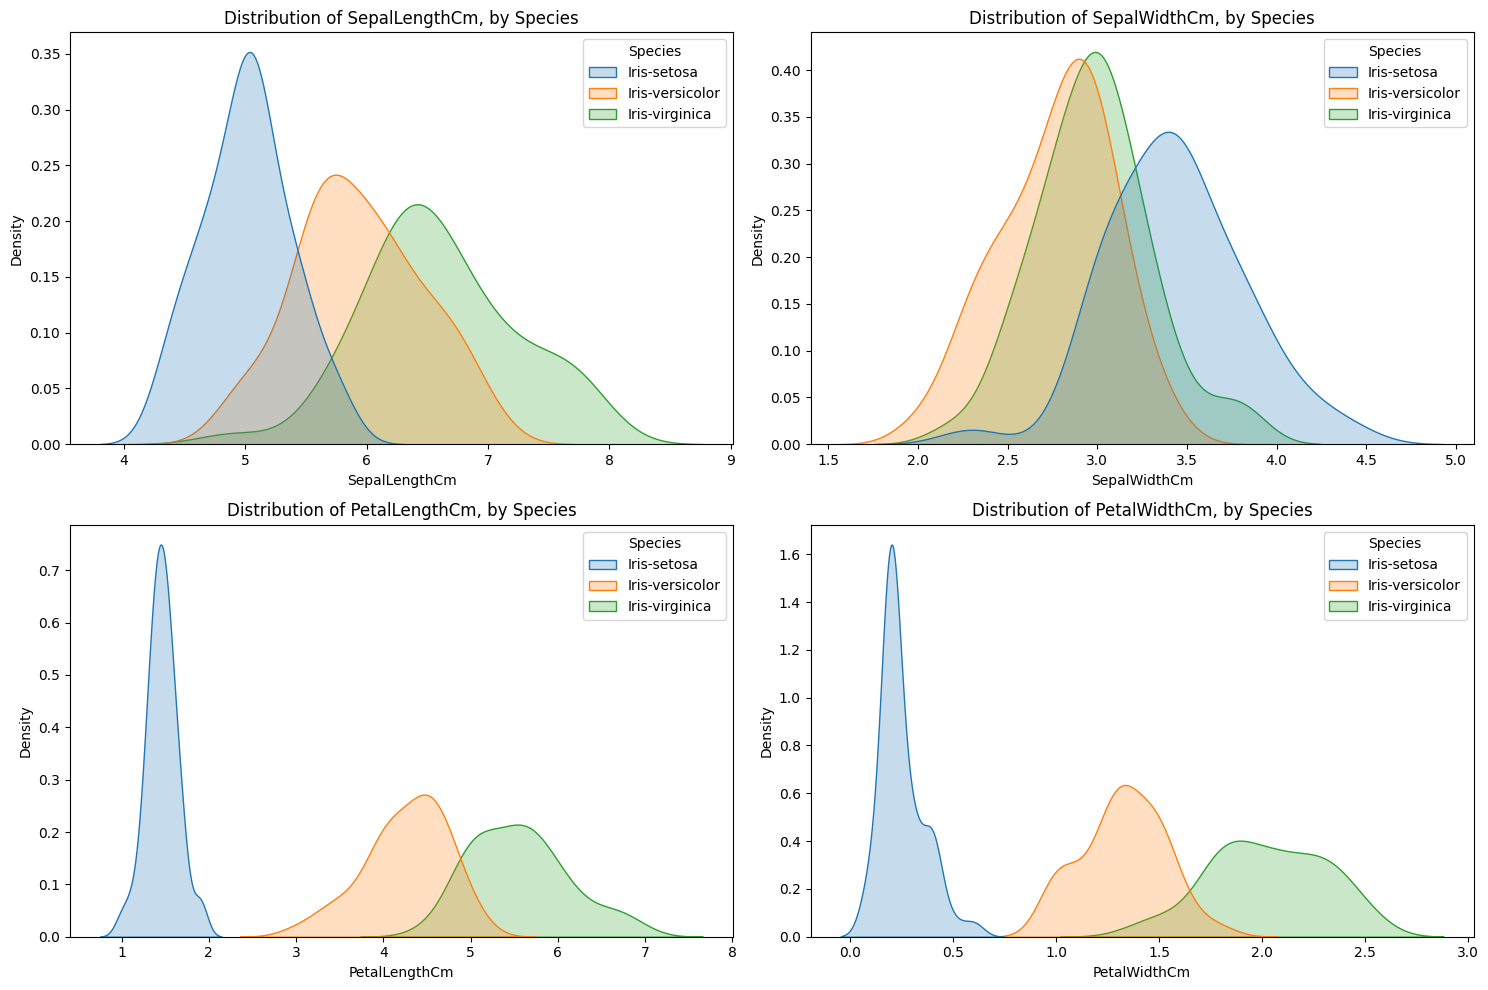

In [8]:
def plot_distributions(data, columns, clf_col):
    """
    Plots distributions of features in the given dataset based on a specified target column.

    Parameters:
        data (DataFrame): The dataset containing the columns to be visualized.
        columns (list): List of column names (features) to visualize.
        clf_col (str): Column name representing the target variable for coloring the distributions.

    Requires:
        - matplotlib.pyplot
        - seaborn

    Returns:
        None
    """

    # Create a figure with subplots
    fig, axes = plt.subplots(2, len(columns) // 2, figsize=(15, 10))

    # Create multiple plots
    for i, column in enumerate(columns):
        # Determine subplot indices
        row = i // (len(columns) // 2)
        col = i % (len(columns) // 2)

        # Create a distribution plot
        sns.kdeplot(data=data, x=column, hue=clf_col, fill=True, ax=axes[row, col])

        # Add title
        axes[row, col].set_title(f"Distribution of {column}, by {clf_col}")

    # Set compact layout
    plt.tight_layout()

    # Show the plots
    plt.show()

# Call the function with the iris_data DataFrame and the grouping variable 'Species'
plot_distributions(iris_data, features, 'Species')

The next step is to create box plots to assess outliers and visually compare our main groups.

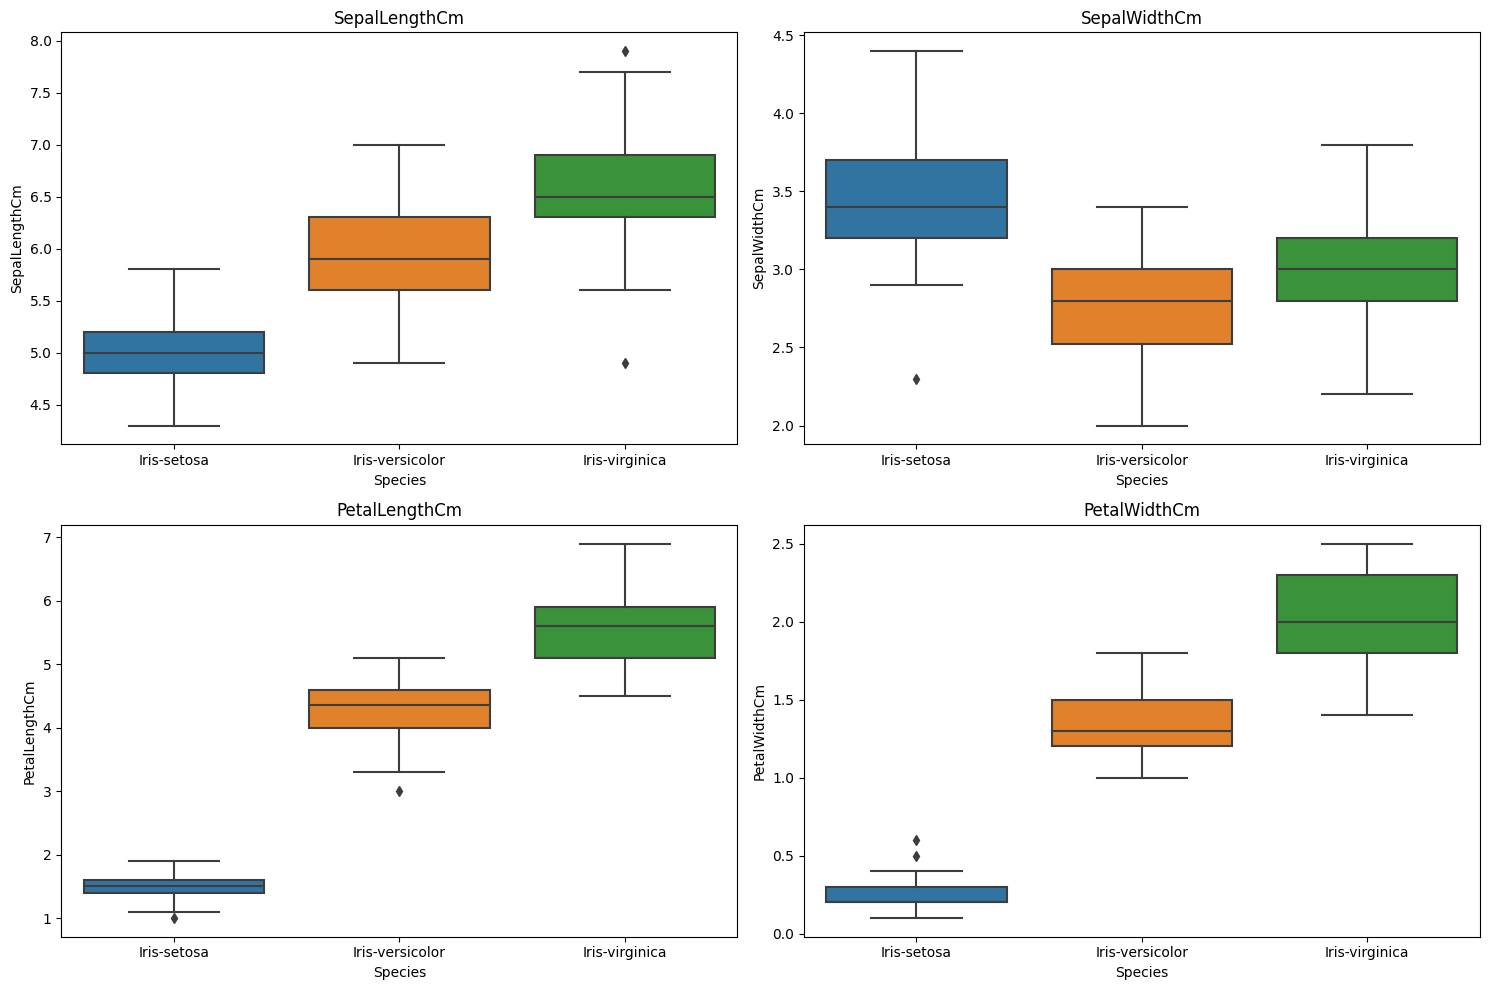

In [9]:
def plot_boxplots(data, columns, clf_col):
    '''
    Function to create boxplots for numerical variables grouped by a specified variable.

    Parameters:
        data (DataFrame): The DataFrame containing the data.
        columns (list): List of numerical variables for which boxplots will be created.
        clf_col (str): The variable for grouping the data.

    Requires:
        - matplotlib.pyplot
        - seaborn

    Returns:
        None
    '''

    # Create subplots for each numerical variable
    fig, axs = plt.subplots(nrows=2, ncols=len(columns)//2, figsize=(15, 10))
    axs = axs.flatten()

    # Iterate through numerical variables
    for i, var in enumerate(columns):
        # Create a boxplot for each variable, grouped by the specified variable
        sns.boxplot(x=clf_col, y=var, data=data, ax=axs[i])
        axs[i].set_title(var)  # Set the title of each subplot

    plt.tight_layout()  # Adjust layout for better appearance
    plt.show()

# Call the function with the iris_data DataFrame and the grouping variable 'Species'
plot_boxplots(iris_data, features, 'Species')

The data contains a small number of outliers. We will use the Interquartile Range (IQR) method to remove them.

In [10]:
# Function to Remove Outliers using Interquartile Range (IQR) method
def remove_outliers_iqr(group):
    '''
    Function to remove outliers using the Interquartile Range (IQR) method.

    Args:
        group (Series): A column or group of data points for outlier removal.

    Requires:
        - pandas (pd)
        - numpy (np)

    Returns:
        Series: Subset of data without outliers.
    '''
    # Calculate the first quartile
    Q1 = group.quantile(0.25)
    
    # Calculate the third quartile
    Q3 = group.quantile(0.75)
    
    # Calculate the interquartile range
    IQR = Q3 - Q1
    
    # Calculate the lower bound
    lower_bound = Q1 - 1.5 * IQR
    
    # Calculate the upper bound
    upper_bound = Q3 + 1.5 * IQR
    
    # Return a subset of data without outliers
    return group[(group >= lower_bound) & (group <= upper_bound)]

# Apply the remove_outliers_iqr function to each feature in features
for feature in features:
    iris_data.loc[:, feature] = iris_data.groupby('Species')[feature].transform(remove_outliers_iqr)

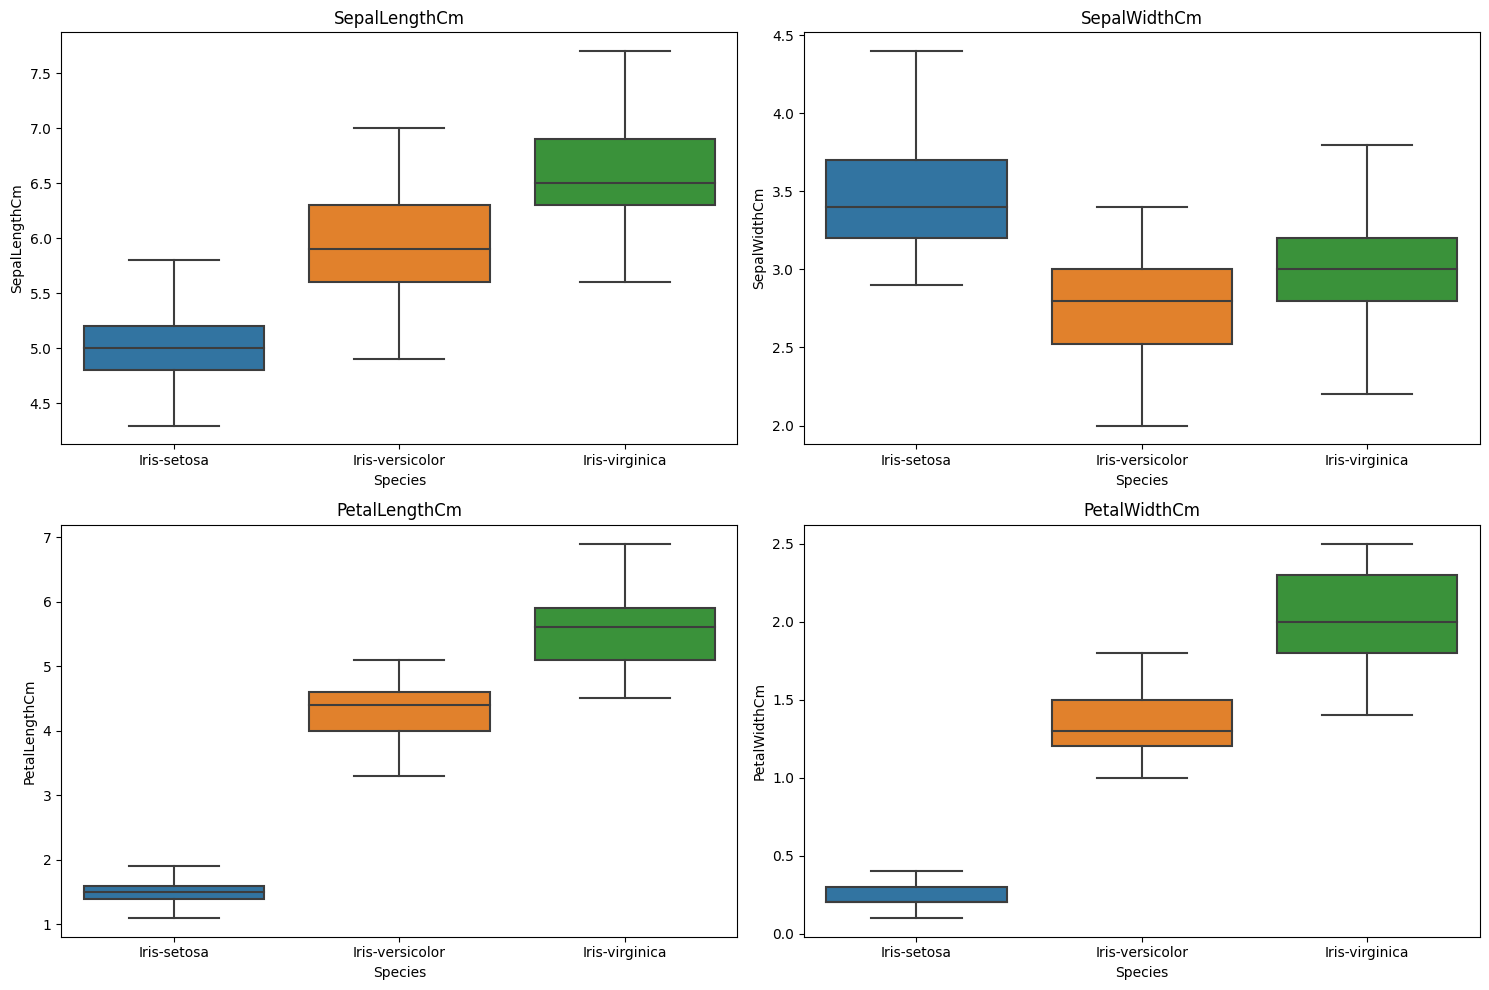

In [11]:
plot_boxplots(iris_data, features, 'Species')

In [12]:
iris_data.isnull().sum()

SepalLengthCm    2
SepalWidthCm     1
PetalLengthCm    2
PetalWidthCm     2
Species          0
dtype: int64

After the implementation of the remove_outliers_iqr function, NaN values have emerged. Let's handle this by replacing them with the mode. Prior to this, let's incorporate numeric codes for our categorical data.


In [13]:
from sklearn.preprocessing import LabelEncoder

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Encode the 'Species' column and create a new column 'code_species' to store encoded values
iris_data['code_species'] = label_encoder.fit_transform(iris_data['Species'])

# Display the first few rows of the DataFrame
iris_data.head()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species,code_species
Id,,,,,,
1,5.1,3.5,1.4,0.2,Iris-setosa,0
2,4.9,3.0,1.4,0.2,Iris-setosa,0
3,4.7,3.2,1.3,0.2,Iris-setosa,0
4,4.6,3.1,1.5,0.2,Iris-setosa,0
5,5.0,3.6,1.4,0.2,Iris-setosa,0


In [14]:
def replace_NaNs_with_mode(dataframe, condition_column, condition_value, target_column):
    '''
    Function to replace NaN values with the mode of a specified column based on a condition.

    Args:
        dataframe (DataFrame): The DataFrame containing the data.
        condition_column (str): The column name for the condition check.
        condition_value: The value for the condition to filter rows.
        target_column (str): The column where NaN values will be replaced with the mode.

    Requires:
        - pandas (pd)

    Returns:
        DataFrame: Updated DataFrame with NaNs replaced by mode for specific conditions.
    '''
    # Find the mode for target_column among rows where condition_column == condition_value
    mode = dataframe[dataframe[condition_column] == condition_value][target_column].mode()[0]

    # Replace NaN values in target_column only for rows where condition_column == condition_value
    dataframe.loc[(dataframe[target_column].isna()) & (dataframe[condition_column] == condition_value), target_column] = mode

    # Return the updated DataFrame
    return dataframe


In [15]:
# Replace missing values
for feature in features:
    for cond_value in [0, 1, 2]:
        iris_data = replace_NaNs_with_mode(iris_data, 'code_species', cond_value, feature)

In [16]:
iris_data.isnull().sum()

SepalLengthCm    0
SepalWidthCm     0
PetalLengthCm    0
PetalWidthCm     0
Species          0
code_species     0
dtype: int64

Let's check if there's any correlation between the groups.

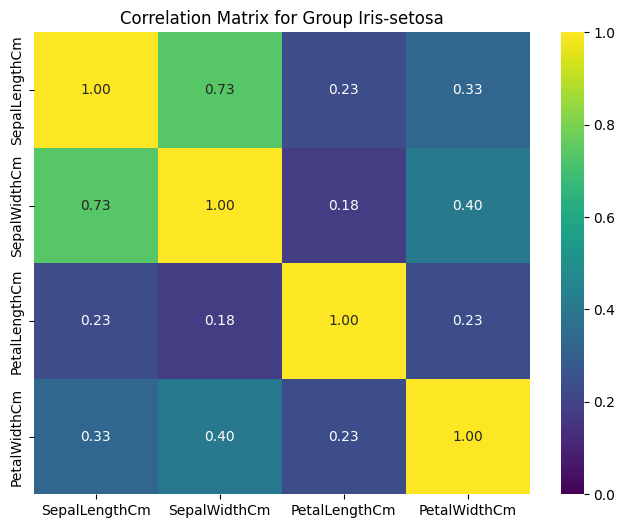

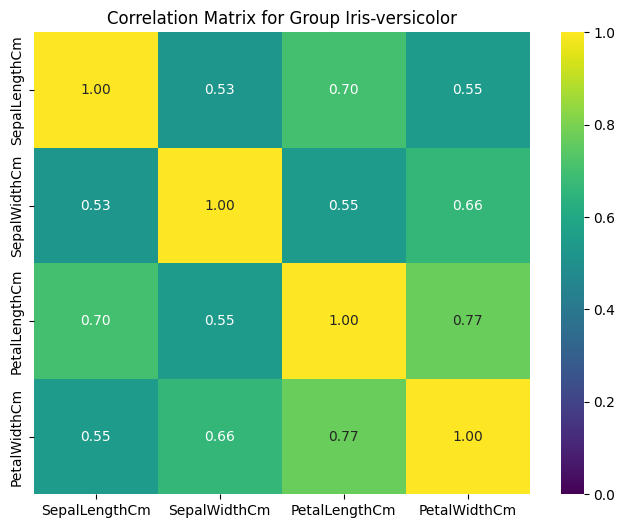

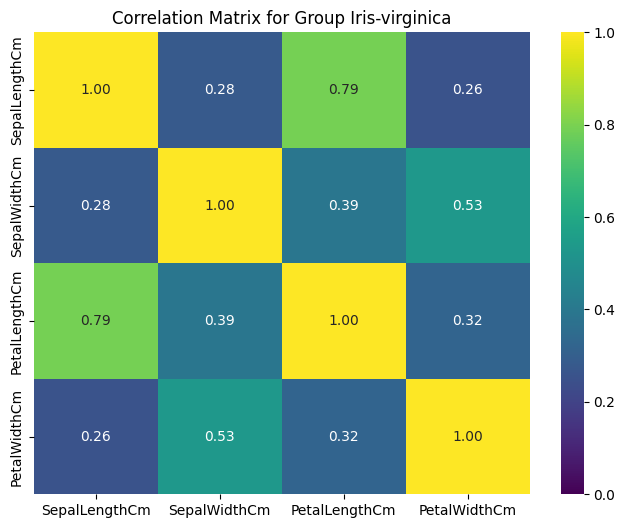

In [17]:
# Split the data into groups
groups = iris_data.groupby('Species')

# Create a correlation matrix for each group
for name, group in groups:
    corr = group.iloc[:, :-2].corr()
    
    # Create a heatmap for the correlation matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr, annot=True, vmax=1, vmin=0, cmap='viridis', fmt=".2f")
    plt.title(f'Correlation Matrix for Group {name}')
    plt.show()

# **Models Training**

**Decision Tree**

In [18]:
# Selecting features for the model
X = iris_data.drop(['code_species', 'Species', 'SepalLengthCm'], axis=1)

# Assigning the target variable
y = iris_data.code_species

The feature SepalLengthCm was excluded as it exhibited high correlation with other variables, and decision trees are sensitive to correlated features.

In [19]:
from sklearn.model_selection import train_test_split

# Splitting the dataset into training and testing sets
# X_train: Training features, X_test: Testing features, y_train: Training target, y_test: Testing target
# test_size=0.33 specifies the proportion of the dataset to include in the test split
# random_state is used for reproducibility to get the same random splits each time
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [20]:
from sklearn import tree

# Creating a Decision Tree Classifier instance
dt = tree.DecisionTreeClassifier(random_state=1)

In [21]:
# Define a dictionary containing different hyperparameters for tuning
parameters = {'max_depth': range(1, 7), 'max_leaf_nodes': range(2, 9)}

In [22]:
from sklearn.model_selection import GridSearchCV

# Create a GridSearchCV object for hyperparameter tuning of the Decision Tree Classifier
# 'dt' is the base classifier model
# 'parameters' is the dictionary of hyperparameters to search over
# 'cv=5' specifies a 5-fold cross-validation strategy for evaluating the performance of each parameter combination
grid_search_clf = GridSearchCV(dt, parameters, cv=5)

In [23]:
grid_search_clf.fit(X_train, y_train)
# Fits the grid search classifier 'grid_search_clf' to the provided training data ('X_train' and 'y_train').
# It performs an exhaustive search over the specified hyperparameter grid ('parametrs') using cross-validation (cv=5)
# to find the best hyperparameters for the Decision Tree Classifier.

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=1),
             param_grid={'max_depth': range(1, 7),
                         'max_leaf_nodes': range(2, 9)})

In [24]:
grid_search_clf.best_params_
# Outputs the best hyperparameters found by the grid search cross-validation process for the Decision Tree Classifier.

{'max_depth': 4, 'max_leaf_nodes': 5}

In [25]:
best_clf = grid_search_clf.best_estimator_
# Assigns the best performing Decision Tree Classifier model obtained from the grid search with optimal hyperparameters.

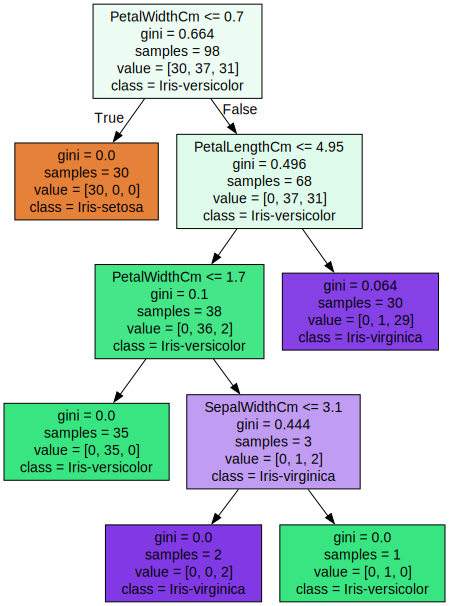

In [26]:
graph = Source(tree.export_graphviz(best_clf, out_file=None
                                   , feature_names=list(X), class_names=['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']
                                   , filled=True))
# Generates a visual representation (graph) of the Decision Tree Classifier with optimal hyperparameters.
# The 'feature_names' parameter specifies the feature names, and 'class_names' denotes the class labels.
# 'filled=True' fills the decision nodes with colors based on the majority class.
display(SVG(graph.pipe(format='svg')))

In [27]:
y_pred = best_clf.predict(X_test)
# Predicts the target values using the best estimator (best_clf) on the test set (X_test).
# This generates predicted labels for the test data.

In [28]:
from sklearn.metrics import f1_score

# Calculate F1-score
f1 = f1_score(y_test, y_pred, average='micro')
# Compute the F1-score to evaluate the performance of the classification model.
# It measures the balance between precision and recall for the given classification predictions.

print(f'F1-score: {f1}')
# Print the computed F1-score value to assess the model's performance.

F1-score: 0.9795918367346939


The F1-score value for this model on the test data is significantly close to 1, indicating that it can be concluded that the model performs well and can be used for further predictions.

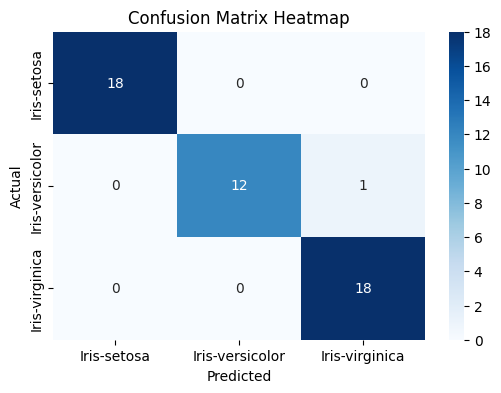

In [29]:
from sklearn.metrics import confusion_matrix

# Creating a confusion matrix using predicted and actual labels
conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix

# Creating a DataFrame from the confusion matrix
df_conf_matrix = pd.DataFrame(conf_matrix, columns=['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'], 
                              index=['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'])

# Visualizing the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(df_conf_matrix, annot=True, cmap='Blues', fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Heatmap')
plt.show()

Here, it can be seen that the model made an error only once out of 49 cases in the test data.

In [30]:
# Calculating feature importances from the best performing decision tree classifier
feature_importances = best_clf.feature_importances_

# Creating a DataFrame to display feature importances
feature_importances_df = pd.DataFrame({'features': list(X_train), 'feature_importances': feature_importances})

# Sorting the DataFrame by feature importances in descending order
feature_importances_df.sort_values('feature_importances', ascending=False)

,features,feature_importances
2,PetalWidthCm,0.534987
1,PetalLengthCm,0.443885
0,SepalWidthCm,0.021128


**k-Nearest Neighbors**

k-NN is not sensitive to feature correlation, so we will use all features for model training.

In [31]:
# Selecting features for the model
X = iris_data.drop(['code_species', 'Species'], axis=1)

# Assigning the target variable
y = iris_data.code_species

In [32]:
# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [33]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

# Create an instance of KNeighborsClassifier
knc = KNeighborsClassifier()

# Define the parameter grid for hyperparameter tuning
parameters = {
    'n_neighbors': range(1, int((X_train.shape[0])**(1/2))),
    'weights': ('uniform', 'distance'),
    'algorithm': ('auto', 'ball_tree', 'kd_tree', 'brute'),
    'metric': ('euclidean', 'manhattan', 'minkowski')
}

# Perform GridSearchCV to find the best hyperparameters
grid_search_knc = GridSearchCV(knc, parameters, cv=5, verbose=1, n_jobs=-1)
grid_search_knc.fit(X_train, y_train)

# Retrieve the best hyperparameters
best_params = grid_search_knc.best_params_
best_params

Fitting 5 folds for each of 192 candidates, totalling 960 fits


{'algorithm': 'auto',
 'metric': 'euclidean',
 'n_neighbors': 3,
 'weights': 'uniform'}

In [34]:
# Retrieve the best performing k-nearest neighbors classifier model obtained from the grid search
best_knc = grid_search_knc.best_estimator_

# Make predictions on the test dataset (X_test) using the best estimator (best_knc) found during the grid search
y_pred = best_knc.predict(X_test)

In [35]:
# Calculate F1-score
f1 = f1_score(y_test, y_pred, average='micro')
# Compute the F1-score to evaluate the performance of the classification model.
# It measures the balance between precision and recall for the given classification predictions.

print(f'F1-score: {f1}')
# Print the computed F1-score value to assess the model's performance.

F1-score: 0.9591836734693877


The F1-score is also quite high, indicating that the model performs well.

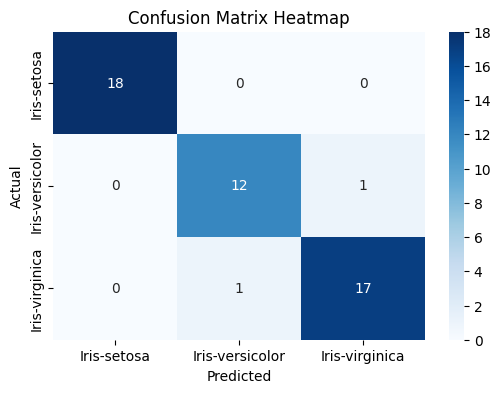

In [36]:
# Creating a confusion matrix using predicted and actual labels
conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix

# Creating a DataFrame from the confusion matrix
df_conf_matrix = pd.DataFrame(conf_matrix, columns=['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'], 
                              index=['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'])

# Visualizing the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(df_conf_matrix, annot=True, cmap='Blues', fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Heatmap')
plt.show()

k-NN model made an error twice.

# **Results**

Having trained both a 'decision tree' and 'k-Nearest Neighbors' models for classifying iris plants into three species, they achieved F1-scores of 0.98 and 0.96 on the test data, respectively. Consequently, the decision tree demonstrates superior performance.